# Advanced Lane Finding


## Project Description

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
%matplotlib inline

### 1) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
### 2) Apply a distortion correction to raw images.

True

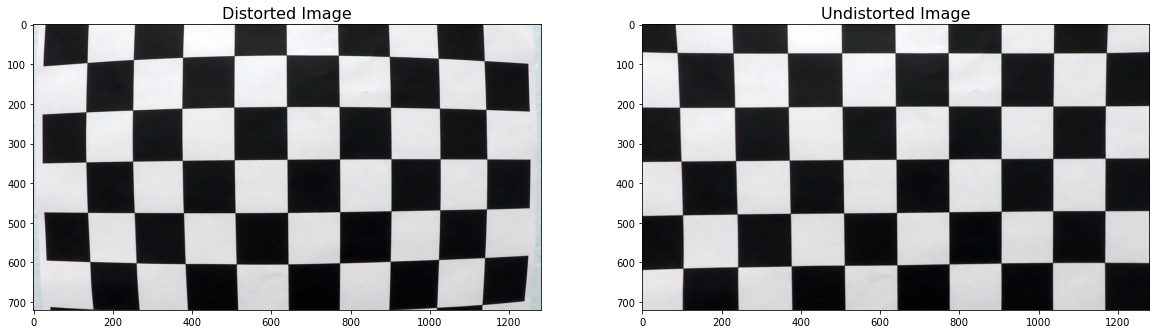

In [11]:
import cv2
import glob

from advanced_lane_finding import plot_images, compute_distortion

# load calibration images
calib_images = glob.glob('camera_cal/*.jpg')

# compute the distortion matrix
matrix, distortion = compute_distortion(calib_images, 9, 6)

# load distorted a test image
distorted_img = cv2.imread('camera_cal/calibration1.jpg')

# undistort the image
undistorted_img = cv2.undistort(distorted_img, matrix, distortion, None, matrix)

# show the images
plot_images([distorted_img, 'Distorted Image'], [undistorted_img, 'Undistorted Image'])
#cv2.imwrite('./output_images/1-undistorted-calibration1.jpg', undistorted_img)

### 3) Use color transforms, gradients, etc., to create a thresholded binary image.

#### 3.1) Calculate Sobel X / Y

True

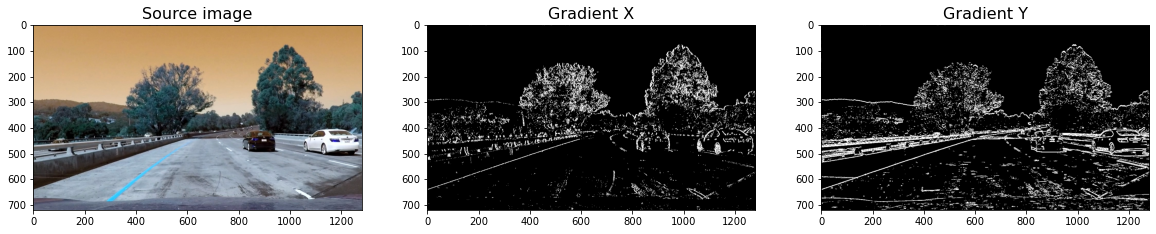

In [12]:
import cv2
from advanced_lane_finding import plot_images, sobel_thresh

# load the test image
img = cv2.imread('test_images/test1.jpg')

# calculate the gradient thresholds
grad_x = sobel_thresh(img, 15, 20, 200, orient='x')
grad_y = sobel_thresh(img, 15, 20, 200, orient='y')

# show the images
plot_images([img, 'Source image'], [grad_x, 'Gradient X'], [grad_y, 'Gradient Y'], num_cols=3)
#cv2.imwrite('./output_images/3-sobel-x.jpg', grad_x)
#cv2.imwrite('./output_images/3-sobel-y.jpg', grad_y)

#### 3.2) Calculate magnitude of the gradient

True

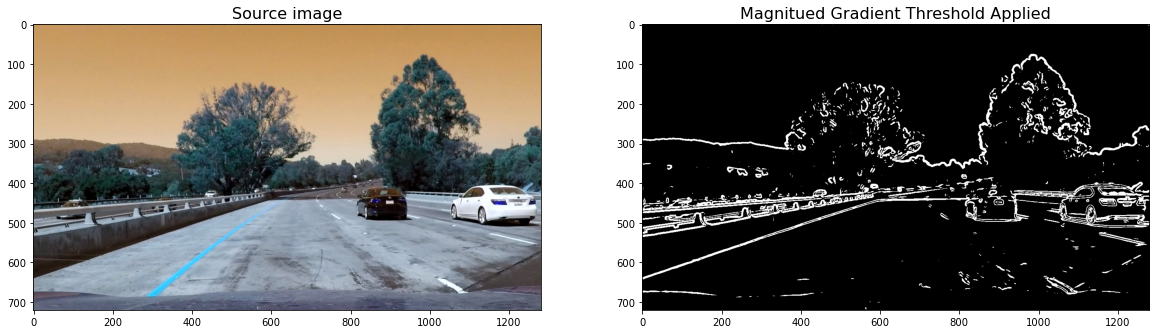

In [13]:
import cv2
from advanced_lane_finding import plot_images, magnitude_threshold

# load the test image
img = cv2.imread('test_images/test1.jpg')

# calculate the gradient magnitude
mag_binary = magnitude_threshold(img, 15, 50, 150)

# display the images
plot_images([img, 'Source image'], [mag_binary, 'Magnitued Gradient Threshold Applied'])
#cv2.imwrite('./output_images/3-magnitude.jpg', mag_binary)

#### 3.3) Calculate the directional magnitude

True

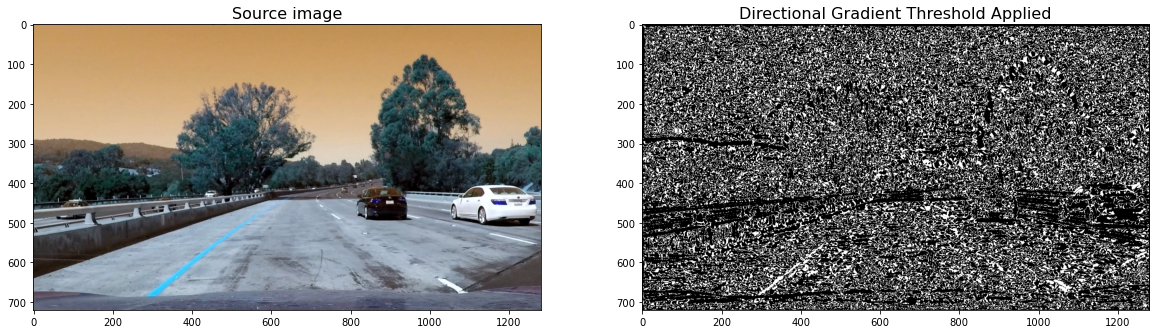

In [14]:
import cv2
from advanced_lane_finding import plot_images, directional_threshold

# load the test image
img = cv2.imread('test_images/test1.jpg')

# compute the directioal magnitude
dir_binary = directional_threshold(img, 15, 0.7, 1.2)

# display
plot_images([img, 'Source image'], [dir_binary, 'Directional Gradient Threshold Applied'])
#cv2.imwrite('./output_images/3-directional.jpg', dir_binary)

#### 3.4) Apply threshold to image with hls color space

True

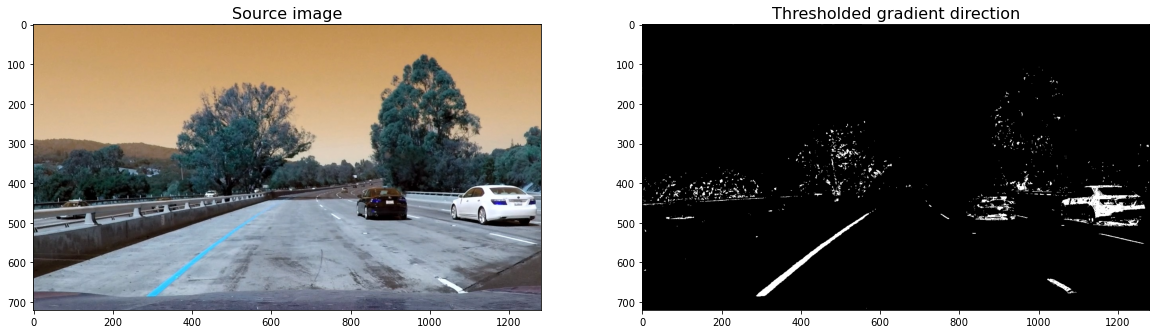

In [15]:
import cv2
from advanced_lane_finding import plot_images, hls_threshold

# load test image
img = cv2.imread('test_images/test1.jpg')

# only select pixels that fall within the threshold 
hls_binary = hls_threshold(img, 160, 255)

# display
plot_images([img, 'Source image'], [hls_binary, 'Thresholded gradient direction'])
#cv2.imwrite('./output_images/3-hls.jpg', hls_binary)

#### 3.5) Combine the all binaries into 1 image

True

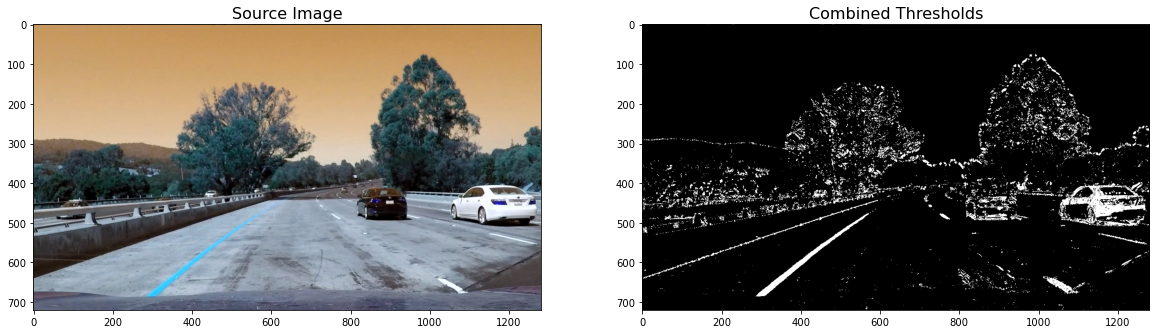

In [16]:
import cv2
from advanced_lane_finding import plot_images, threshold_binary

# load the test image
img = cv2.imread('test_images/test1.jpg')

# use the helpter function to get the image of the combined thresholds
combined_binary = threshold_binary(img)

# display
plot_images([img, 'Source Image'], [combined_binary, 'Combined Thresholds'])
#cv2.imwrite('./output_images/3-combined.jpg', combined_binary)

### 4) Apply a perspective transform to rectify binary image ("birds-eye view").

True

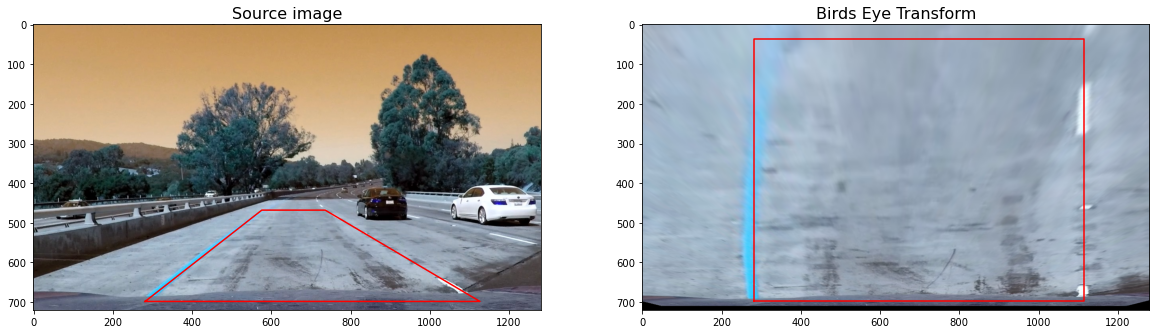

In [17]:
import cv2
from advanced_lane_finding import plot_images, birds_eye_transform, matrix_to_polygon

# load the test image
img = cv2.imread('test_images/test1.jpg')

# run the transform using the default matrix
bet = birds_eye_transform(img)

# get the source and destination polygons for display
src_p, dst_p = matrix_to_polygon(img=img)

# display
plot_images([img, 'Source image', src_p], [bet, 'Birds Eye Transform', dst_p])
#cv2.imwrite('./output_images/4-birds-eye-transform.jpg', bet)

### 5) Detect lane pixels and fit to find the lane boundary.


####  5.1) Use a histogram to map image point counts to find dense areas of pixels in the x direction

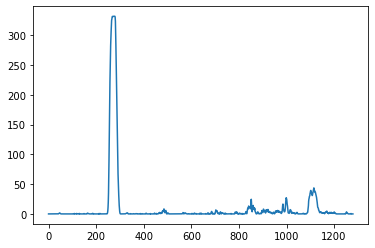

In [1]:
import cv2
import matplotlib.pyplot as plt

from advanced_lane_finding import plot_images, calculate_hist, threshold_binary, birds_eye_transform

# load the test image
img = cv2.imread('test_images/test1.jpg')

# compute the combined binary and then run the transform to isolate pixels of interest
combined_binary = threshold_binary(img)
birds_eye_bin = birds_eye_transform(combined_binary)

# use a histogram to find the densest portion of the image
histogram = calculate_hist(birds_eye_bin)

# display
plt.plot(histogram)

#### 5.2) Fit a polynomial to the line using the histogram for each window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


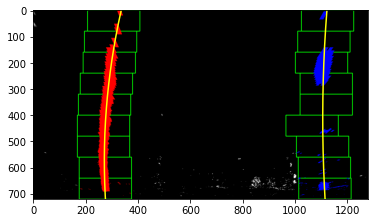

In [1]:
import cv2
import matplotlib.pyplot as plt

from advanced_lane_finding import plot_images, calculate_hist, threshold_binary, birds_eye_transform, \
    fit_polynomial, show_polynomial

# load the test image
img = cv2.imread('test_images/test1.jpg')

# create the combined binary image, run the transform so we can isolate pixels of interest and create a fit
combined_binary = threshold_binary(img)
birds_eye_bin = birds_eye_transform(combined_binary)

# create the fit
left_fit, right_fit, result = fit_polynomial(birds_eye_bin, output_debug=True)

# display
show_polynomial(result, left_fit, right_fit)

#### 5.3) Use the existing fit to search for the lane line in the most probable area

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

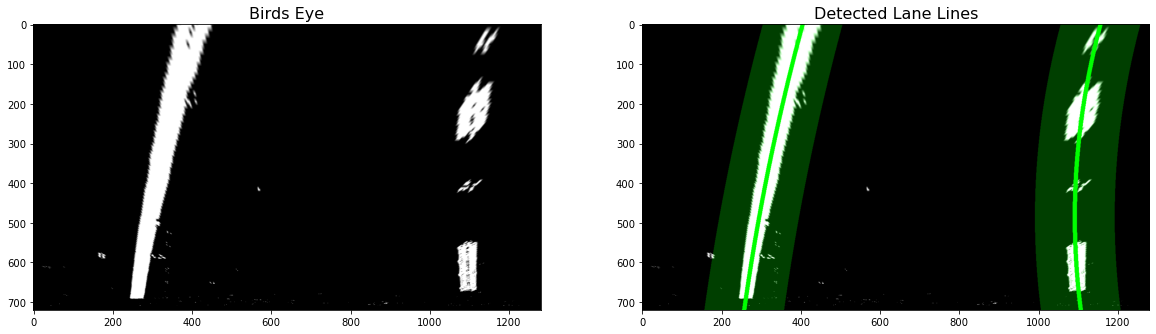

In [18]:
import cv2
import matplotlib.pyplot as plt

from advanced_lane_finding import plot_images, calculate_hist, threshold_binary, birds_eye_transform, \
    fit_polynomial, show_polynomial, search_around_poly, overlay_search_area, add_lines, binary_to_img

# load the image
source_image = cv2.imread('test_images/test3.jpg')

# get the binary image with the default thresholds
source_threshold_binary = threshold_binary(source_image)

# transform to get the birds eye view
birds_eye = birds_eye_transform(source_threshold_binary)

# calculate the initial fit
left_fit, right_fit, birds_eye_lane_fit_a = fit_polynomial(birds_eye)

# use the left and right fit to search the calculate fits on a specific search area
left_fit, right_fit = search_around_poly(birds_eye, left_fit, right_fit)

# add the detected lines and overlay
out_img = binary_to_img(birds_eye)

# add debugging visuals to the image
out_img = add_lines(out_img, left_fit)
out_img = add_lines(out_img, right_fit)
out_img = overlay_search_area(left_fit, right_fit, img=out_img)

# display
plot_images([birds_eye, 'Birds Eye'], [out_img, 'Detected Lane Lines'])
#cv2.imwrite('./output_images/5-detected-lane-lines.jpg', out_img)

### 6) Determine the curvature of the lane and vehicle position with respect to center.

In [8]:
import cv2
import matplotlib.pyplot as plt

from advanced_lane_finding import plot_images, calculate_hist, threshold_binary, birds_eye_transform, \
    fit_polynomial, calculate_curvature, car_offset

# load the image
source_image = cv2.imread('test_images/test1.jpg')

# get the binary image with the default thresholds
source_threshold_binary = threshold_binary(source_image)

# transform to get the birds eye view
birds_eye = birds_eye_transform(source_threshold_binary)

# calculate the initial fit
left_fit, right_fit, img = fit_polynomial(birds_eye)

#  calculate lane curvature and offset
curvature = calculate_curvature(left_fit, right_fit, birds_eye.shape)
offset = car_offset(left_fit, right_fit, birds_eye.shape)

# display
print(f'Left Curvature:  {curvature[0]}m')
print(f'Right Curvature: {curvature[1]}m')
print(f'Offset:          {offset}m')

Left Curvature:  842.4702587543014m
Right Curvature: 1755.2507382035321m
Offset:          -0.2903338629102226m


### 7) Warp the detected lane boundaries back onto the original image.

True

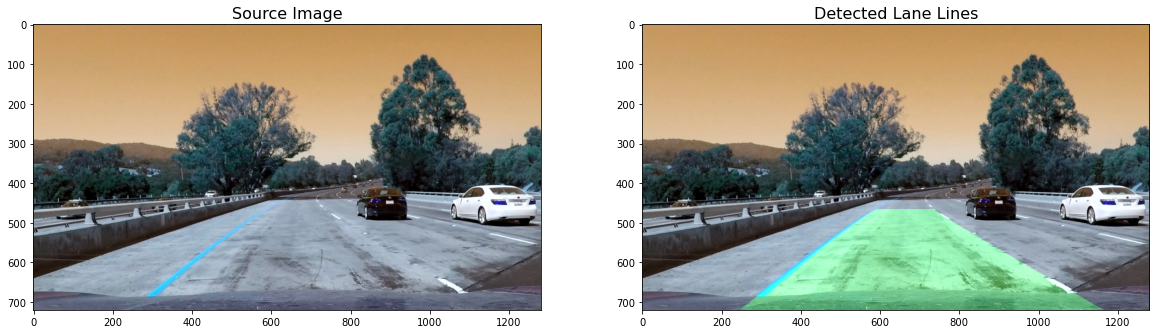

In [19]:
import cv2
import matplotlib.pyplot as plt

from advanced_lane_finding import plot_images, calculate_hist, threshold_binary, birds_eye_transform, \
    fit_polynomial, calculate_curvature, car_offset, draw_lane, birds_eye_transform_matrix

# load the image
source_image = cv2.imread('test_images/test1.jpg')

# get the transform matrix
matrix, inv_matrix = birds_eye_transform_matrix(source_image.shape[1], source_image.shape[0])

# get the binary image with the default thresholds
source_threshold_binary = threshold_binary(source_image)

# transform to get the birds eye view
birds_eye = birds_eye_transform(source_threshold_binary)

# calculate the initial fit
left_fit, right_fit, img = fit_polynomial(birds_eye)

# for display purposes add the detected lane on the image
img = draw_lane(source_image, left_fit, right_fit, inv_matrix)

# display
plot_images([source_image, 'Source Image'], [img, 'Detected Lane Lines'])
#cv2.imwrite('./output_images/7-lane-boundaries.jpg', img)

# 8) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

True

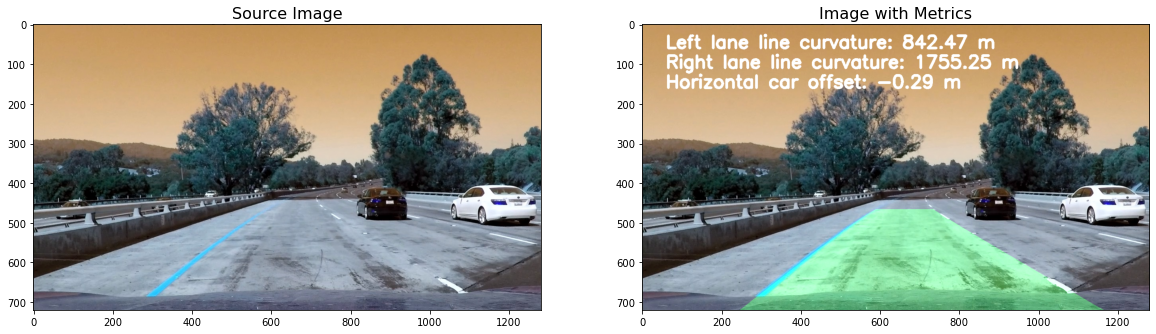

In [22]:
import cv2
import matplotlib.pyplot as plt

from advanced_lane_finding import plot_images, calculate_hist, threshold_binary, birds_eye_transform, \
    fit_polynomial, calculate_curvature, car_offset, draw_lane, birds_eye_transform_matrix, add_metrics

# load the image
source_image = cv2.imread('test_images/test1.jpg')

# get the transform matrix
matrix, inv_matrix = birds_eye_transform_matrix(source_image.shape[1], source_image.shape[0])

# get the binary image with the default thresholds
source_threshold_binary = threshold_binary(source_image)

# transform to get the birds eye view
birds_eye = birds_eye_transform(source_threshold_binary)

# calculate the initial fit
left_fit, right_fit, img = fit_polynomial(birds_eye)

# calculate the curvature and offset
left_curvature, right_curvature = calculate_curvature(left_fit, right_fit, birds_eye.shape)
offset = car_offset(left_fit, right_fit, birds_eye.shape)

# add the lane and metrics to the image
img = add_metrics(source_image, left_curvature, right_curvature, offset)
img = draw_lane(img, left_fit, right_fit, inv_matrix)

# display
plot_images([source_image, 'Source Image'], [img, 'Image with Metrics'])
#cv2.imwrite('./output_images/8-image-w-metrics.jpg', img)

### 9) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [10]:
from advanced_lane_finding import ProcessImage
from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_video = './project_video.mp4'
output_video = './output_images/9-project_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./project_video_solution.mp4.
Moviepy - Writing video ./project_video_solution.mp4



Moviepy - Done !
Moviepy - video ready ./project_video_solution.mp4
CPU times: user 10min 40s, sys: 31 s, total: 11min 11s
Wall time: 5min 26s
